In [1]:
from datasets import load_dataset, concatenate_datasets
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

from rouge_score import rouge_scorer
from transformers import AutoModelForCausalLM, AutoTokenizer, StoppingCriteria, StoppingCriteriaList

import math
import numpy as np
import torch
import os
import re

import spacy
nlp = spacy.load("en_core_web_sm")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [4]:
summary_train_ds = load_dataset('amang1802/summary_train')

In [5]:
device = torch.device("cuda:0")

In [6]:
pattern = re.compile(r'Summarize the text using exactly (\d+) words:')
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def parse_target_words(query):
    match = re.search(pattern, query)
    return int(match.group(1))


def word_count(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.is_alpha)


def get_reward(queries_batch, response_batch):
    queries = torch.tensor([q['input_ids'][0] for q in queries_batch])
    responses = torch.tensor(response_batch)
    
    query_strs = tokenizer.batch_decode(queries)
    target_word_lengths = torch.tensor([parse_target_words(query)
                                        for query in query_strs]).float()
    
    response_strs = tokenizer.batch_decode(responses, skip_special_tokens=True)
    word_lengths = torch.tensor([word_count(text)
                                 for text in response_strs]).float()

    ldiff = target_word_lengths - word_lengths
    rewards = torch.exp(0.7 * -torch.abs(ldiff) + torch.log(torch.tensor(2))) - 1
    
    return {"reward": rewards.tolist(), "ldiff": ldiff.tolist(), "generation": response_strs}


def get_rouge_score(row):
    choice = row['choice']
    chosen = row['summaries'][choice]['text']
    score = scorer.score(chosen, row['generation'])
    
    return { 'rouge1': score['rouge1'].fmeasure, 'rougeL': score['rougeL'].fmeasure }

In [7]:
class StopEoT(StoppingCriteria):
    def __init__(self, stop_id=128009):
        self.stop_token = '<|eot_id|>'

    def __call__(self, input_ids, scores, **kwargs):
            return self.stop_token == tokenizer.decode(input_ids[-1])

stopping_criteria = StoppingCriteriaList([StopEoT()])

def generate_responses(queries_batch):
    inputs, masks = zip(*[(query['input_ids'][0], query['attention_mask'][0])
                          for query in queries_batch])
    
    inputs = torch.tensor(list(inputs))
    masks = torch.tensor(list(masks))
    
    outputs = model.generate(inputs=inputs.to(device),
                             attention_mask=masks.to(device),
                             max_new_tokens=64,
                             do_sample=False,
                             top_p=None,
                             temperature=None,
                             stopping_criteria=stopping_criteria
                            )

    response_only = outputs[:, inputs.shape[1]:]
    
    return {"generated_tokens": list(torch.unbind(response_only, dim=0))}

# Trainer

In [8]:
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map={"": device.index})
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [9]:
# Output these tensors
# X, with shape (batch_size, 1024). These are the inputs.
# Y, with shape (batch_size, 1024). This is almost exactly the same as X,
#    only shifted by 1
# R, with shape (batch_size, 1024). These are the rewards for each token. 
#    We mask out the tokens we don't want to reward.
def dataloader(ds, start, end):
    batch = ds.select(range(start,end))
    batch = batch.map(generate_responses, batch_size=128, batched=True, 
                      input_columns=['tokens'])
    batch = batch.map(get_reward, batched=True, batch_size=128,
                      input_columns=['tokens', 'generated_tokens'])
    
    batch_size = end - start
    inputs = torch.tensor([t['input_ids'][0] for t in batch['tokens']])
    outputs = torch.tensor(batch['generated_tokens'])
    rewards = torch.tensor(batch['reward'])

    X = torch.cat([inputs, outputs[:, :-1]], dim=1)
    Y = torch.cat([inputs[:, 1:], outputs], dim=1)

    # we don't want to train on input - so the input tokens are masked out
    labels_mask = torch.cat([torch.zeros_like(inputs),
                             torch.ones((batch_size, outputs.shape[1]-1))], dim=1)
    # hacky way to mask out the token used for padding
    labels_mask = labels_mask * (Y != 128001).int()
    
    R = (torch.ones_like(Y) * rewards.unsqueeze(dim=1)) * labels_mask

    # I just like the number 1024 - since inputs.shape[1] is 1024, 
    # and I know there is enough padding in the input,
    # I make the X.shape[1] and Y.shape[1] also 1024. 
    # It also supposedly makes matrix multiplication faster in nvidia GPUs!
    return X[:, outputs.shape[1]-1:], Y[:, outputs.shape[1]-1:], R[:, outputs.shape[1]-1:], batch


def eval_loss(eval_ds, batch_size):
    print("Computing eval loss...")
    model.eval()

    batch_ds = []
    with torch.no_grad():
        accu_loss = 0.0
        for index in range(0, eval_ds.num_rows, batch_size):
            X, Y, R, single_batch_ds = dataloader(eval_ds, index, index+batch_size)
            batch_ds.append(single_batch_ds)
            accu_loss += forward(X, Y, R).item()

    loss_normalized = accu_loss / (eval_ds.num_rows / batch_size)

    batch_ds = concatenate_datasets(batch_ds)
    
    ldiff = np.array(batch_ds['ldiff'])
    ldiff_mean, ldiff_std = ldiff.mean(), ldiff.std()
    
    batch_ds = batch_ds.map(get_rouge_score)
    rouge1, rougeL = np.array(batch_ds['rouge1']).mean(), np.array(batch_ds['rougeL']).mean()
    
    return loss_normalized, ldiff_mean, ldiff_std, rouge1, rougeL
    

def forward(X, Y, R):
    X, Y, R = X.to(device), Y.to(device), R.to(device)

    output = model(X)
    # output.logits have the shape (batch_size, input_length - 1024, vocab_size)
    logprobs = output.logits.log_softmax(dim=2)
    P_y_x = logprobs.gather(2, Y.unsqueeze(2)).squeeze()

    # We want a positive loss for descent. P_y_x elements are negative.
    # If reward is negative P_y_x*R is positive.
    loss = (P_y_x * R).mean()
        
    return loss


def training_loop(train_ds, test_ds):
    num_epochs = 1
    batch_size = 4
    gradient_accu_steps = 8
    eval_interval = 4
    max_samples = min(train_ds.num_rows, 10e9)

    num_steps_per_epoch = math.ceil(train_ds.num_rows / (batch_size * gradient_accu_steps))
    print(f"Num steps per epoch: {num_steps_per_epoch}")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
    training_losses = []
    eval_losses = []
    ldiff_means = []
    ldiff_stds = []
    rouge1s = []
    rougeLs = []

    model.train()
    for epoch in range(num_epochs):
        accu_loss = 0.0
        for num_batch, index in enumerate(range(0, max_samples, batch_size)):
            step = ((num_batch+1) // gradient_accu_steps) + epoch * num_steps_per_epoch
            print(f"Step: {step}, Num Physical Batch: {num_batch}")
            
            X, Y, R, _ = dataloader(train_ds, index, index+batch_size)
            loss = forward(X, Y, R) / gradient_accu_steps
            accu_loss += loss.item()
            loss.backward()
            
            if (num_batch+1) % gradient_accu_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

                print(f"Training Loss: {accu_loss}")
                training_losses.append((step, accu_loss))
                accu_loss = 0

                if step % eval_interval == 0:
                    model.eval()
                    e_loss, ldiff_mean, ldiff_std, rouge1, rougeL = eval_loss(test_ds, batch_size)
                    model.train()
                    print(f"Eval Loss: {e_loss}")
                    
                    eval_losses.append((step, e_loss))
                    ldiff_means.append((step, ldiff_mean))
                    ldiff_stds.append((step, ldiff_std))
                    rouge1s.append((step, rouge1))
                    rougeLs.append((step, rougeL))

    return {
        "training_loss": training_losses,
        "eval_loss": eval_losses,
        "ldiff_mean": ldiff_means,
        "ldiff_std": ldiff_stds,
        "rouge1": rouge1s,
        "rougeL": rougeLs
    }


In [10]:
# loss_dict: key is the name of the loss, mapped to an array of tuples (step_number, value)
loss_dict = training_loop(summary_train_ds['train'], summary_train_ds['test'].select(range(64)))

Num steps per epoch: 32
Step: 0, Num Physical Batch: 0
Step: 0, Num Physical Batch: 1
Step: 0, Num Physical Batch: 2
Step: 0, Num Physical Batch: 3
Step: 0, Num Physical Batch: 4
Step: 0, Num Physical Batch: 5
Step: 0, Num Physical Batch: 6
Step: 1, Num Physical Batch: 7
Training Loss: 0.3380879694595933
Step: 1, Num Physical Batch: 8
Step: 1, Num Physical Batch: 9
Step: 1, Num Physical Batch: 10
Step: 1, Num Physical Batch: 11
Step: 1, Num Physical Batch: 12
Step: 1, Num Physical Batch: 13
Step: 1, Num Physical Batch: 14
Step: 2, Num Physical Batch: 15
Training Loss: 0.22351641952991486
Step: 2, Num Physical Batch: 16
Step: 2, Num Physical Batch: 17
Step: 2, Num Physical Batch: 18
Step: 2, Num Physical Batch: 19
Step: 2, Num Physical Batch: 20
Step: 2, Num Physical Batch: 21
Step: 2, Num Physical Batch: 22
Step: 3, Num Physical Batch: 23
Training Loss: 0.07545130717335269
Step: 3, Num Physical Batch: 24
Step: 3, Num Physical Batch: 25
Step: 3, Num Physical Batch: 26
Step: 3, Num Physi

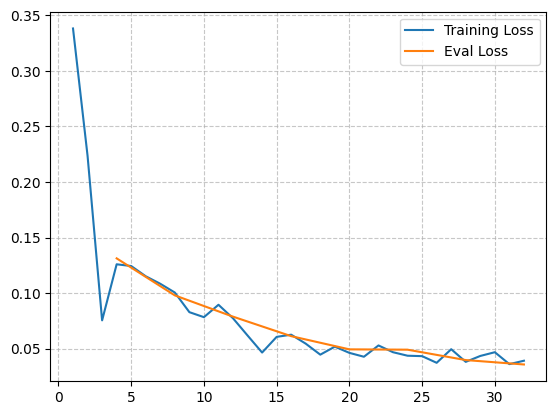

In [11]:
train_steps, train_losses = zip(*loss_dict['training_loss'])
eval_steps, eval_losses = zip(*loss_dict['eval_loss'])
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Eval Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

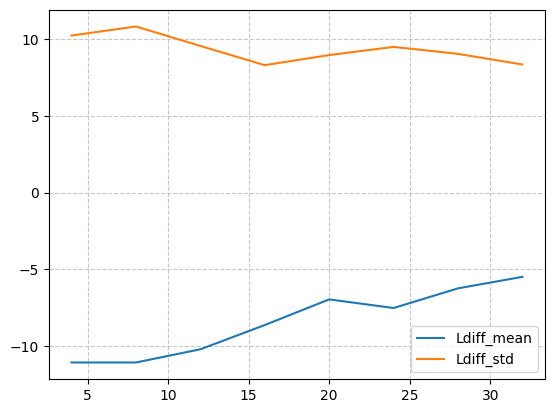

In [12]:
ldiff_mean_steps, ldiff_mean_losses = zip(*loss_dict['ldiff_mean'])
ldiff_std_steps, ldiff_std_losses = zip(*loss_dict['ldiff_std'])
plt.plot(ldiff_mean_steps, ldiff_mean_losses, label='Ldiff_mean')
plt.plot(ldiff_std_steps, ldiff_std_losses, label='Ldiff_std')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

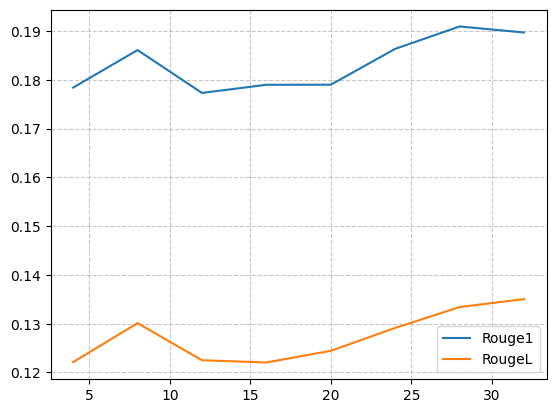

In [13]:
rouge1_steps, rouge1_losses = zip(*loss_dict['rouge1'])
rougeL_steps, rougeL_losses = zip(*loss_dict['rougeL'])
plt.plot(rouge1_steps, rouge1_losses, label='Rouge1')
plt.plot(rougeL_steps, rougeL_losses, label='RougeL')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

In [14]:
#new_model_id = "Llama3.2-1B-summary-length-exp5"

In [15]:
#model.push_to_hub(new_model_id)
#tokenizer.push_to_hub(new_model_id)